# Face Recognition Project

В этом проектк вы познакомитесь с задачей распознавания лиц, узнаете, как ее решать, и построите свой пайплан для решения этой задачи.

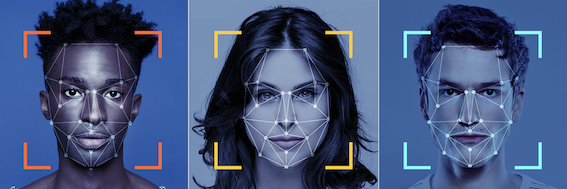

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии. После этого в разделе "задача проекта" расписано то, что нужно/можно делать в рамках этого проекта. **Пожалуйста, перед началом работы по проекту внимательно прочитайте раздел "задача проекта"!**

Ну а перед этим всем лучше разберемся с тем, какую задачу вообще мы хотим решать.

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

## Пайплайн для распознавания лиц, его обучение и тест

В этой части описано устройство пайплайна для распознавания лиц, а также принцип его обучения и тестирования.

### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

#### Детекция лиц

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

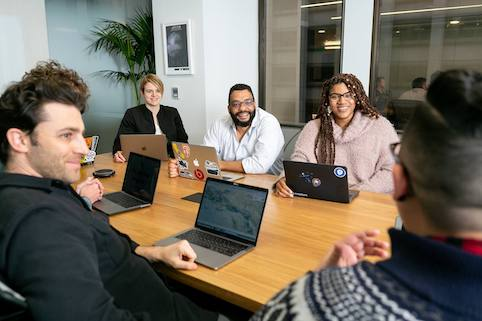

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

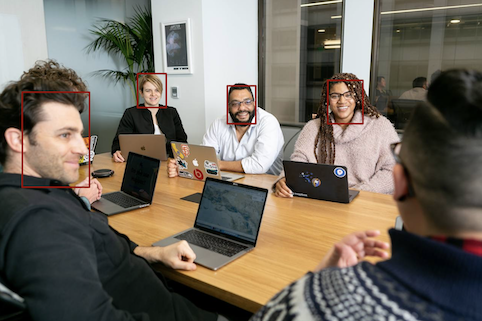

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

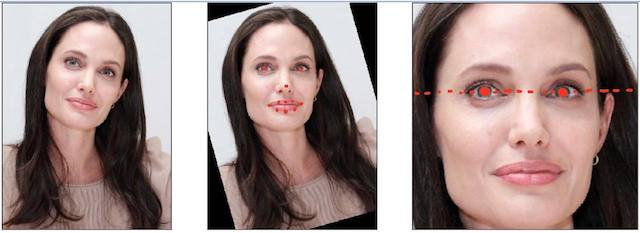

Таким образом, после второго этапа лица выглядят как-то так:

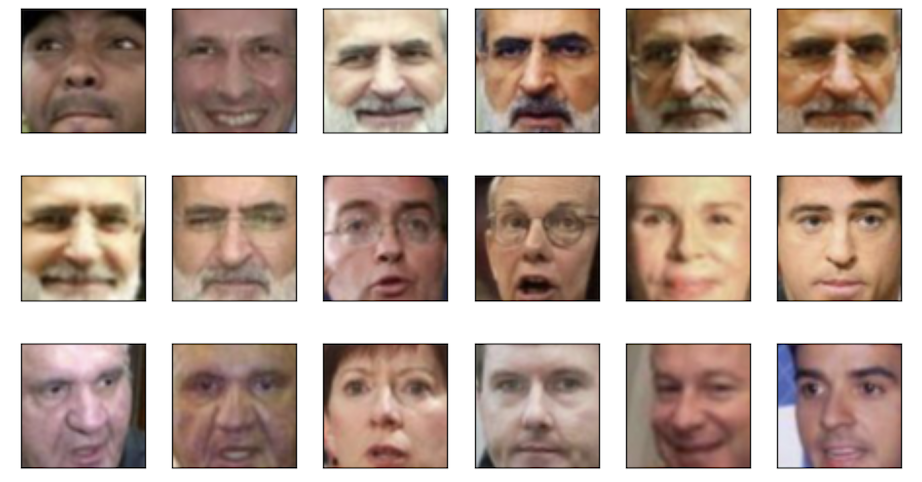

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.

#### Распознавание лиц

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



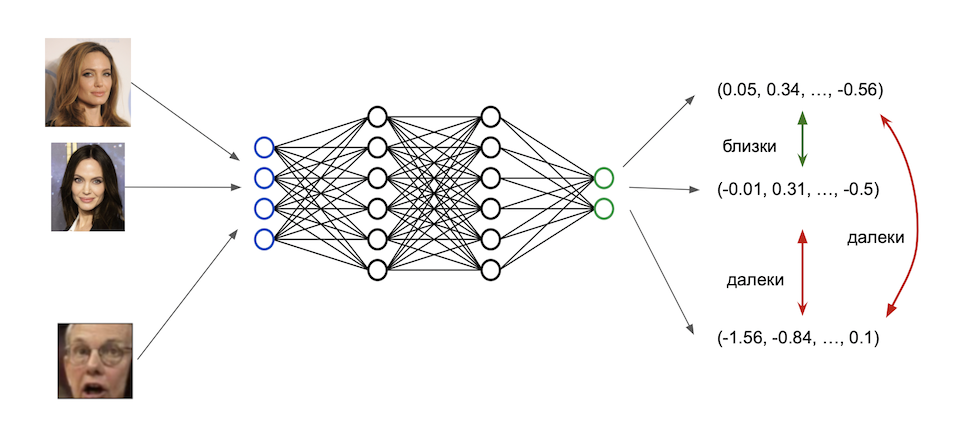

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

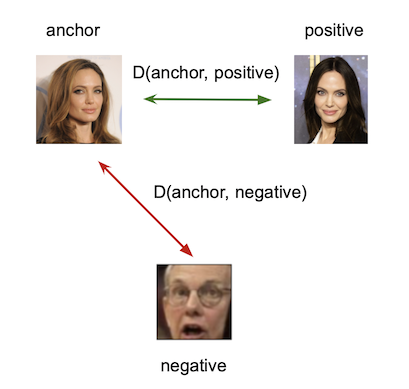

Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.
- первая часть — это просто задача детекции;
- вторая часть — задача выравнивания фотографии лица;
- третья часть — задача распознавания лица по выровненной фотографии.

### Метрика качества для 3 части пайплайна

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

### Лосс-функции для 3 части пайплайна

Выше мы поняли, что нейросеть для распознавания лиц можно обучать разными способами. Два, которые мы упомянули — обучение сети на задачу классификации и с помощью contrastive loss. Давайте поговорим о том, какие лосс-функции мы можем использовать в том и в другом случае.



#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

#### Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batchnorm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

#### Другие лосс-функции

Кроме ArcFace и Triplet Loss, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

## Задача проекта

В целом, **задача проекта — реализовать один или несколько частей системы распознавания лиц**. Вот что можно делать:

- (2 балла, обязательная часть!) Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации.
- (2 балла) Обучить нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. реализовать вторую часть пайплайна face recognition);
- (2 балла) Собрать весь пайплайн распознавания лиц. Этому пайплайну должно быть можно подать на вход картинку с лицами, и пайплайн должен возвращать эмбеддинги всех найденных лиц. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами. В пайплайне можно использовать предобученную сеть для детекции лиц, или же обучить свою;
- (2 балла) Реализовать Identification Rate Metric (ниже дан щаблон кода для него и ячейки для тестирования);
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (2 балла) Реализовать Triplet loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (1 балл) Обучить сеть на смеси ArcFace loss и Triplet loss. Добиться достаточного качества классификации;
- (2 балла) Исследовать литературу, статьи по Face Recognition, написать literature review с обзором современных методов, улучшений сети и пайплайна.
- (2 балла) Исследовать пространство полученных эмбеддингов. Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?
- Улучшить сеть с помощью разных трюков. Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить. Баллы тут зависят от сложности улучшения и вашей иреализации.

Пожалуйста, пишите подробные комментарии к своему коду. Вставляйте ссылки на статьи, где нашли какие-то трюки. Объясняйте, почему реализовали что-то именно так. Будет классно, если вы опишете свой путь в экспериментах при работе с оубчением модели или Triplet Loss.


**Данные. Какие данные можно использовать для выполнения проекта:**

Для третьей части пайплайна (нейросети для распознавания лиц) есть такие варианты:
- Я подготовила данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw
    Внутри:
        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.
- Использовать любые другие данные. Например, можно взять больше картинок из [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). Или вот еще один популярный датасет: [LFW](https://colab.research.google.com/corgiredirector?site=http%3A%2F%2Fvis-www.cs.umass.edu%2Flfw%2F). Обращайте внимание на то, выровнены ли лица в том датасете, который вы скачиваете, и кропайте картинки так, чтобы на них оставалось преимущественно лицо.


Может быть удобно сначала проверить вашу сеть на данных CelebA-500, а затем переходить к ее обучению на большем датасете.

Для обучения других частей пайплайна данные нужно выбрать самим. Разные части пайплайна можно обучать на разных данных. Но нужно, чтобы затем весь пайплайн хорошо работал на новых лицах.

- Для тестирования кода Identification Rate Metric я также подготовила данные из CelebA, которые выровнены точно так же, как картинки из CelebA-500. Если вы обучили нейросеть на датасете CelebA-500, можете ее тестировать с помощью этих данных. Ссылка на них есть в разделе "шаблон кода для Identification Rate Metric" ниже в ноутбуке.



**Проект оценивается из 10 баллов. Чтобы проект считался сданным, нужно набрать 5 или более баллов.**  Можно выполнять любые части проекта, которые описаны выше, баллы будут суммироваться. Единственная обязательная часть — обучение сети с нуля на CE loss.

Самый простой (на мой взгляд) набрать 6 баллов:
- (2 балла) Обучить нейросеть для распознавания лиц на датасете CelebA-500. Чтобы получить два балла, нужно добиться accuracy на тестовой части >0.7;
- (2 балла) Реализовать Identification Rate Metric, протестировать ее на предоставленных данных;
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7;



# **Начнем с обязательной части**(2 балла)

 Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации.

 Использую данные - картинки из выборки CelebA-500

Попробую модель Resnet50

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [15]:
# Словарь для хранения разбиений(для проверки)
splits = {}

# Чтение файла с разбиением
with open("/Users/olgashalashova/Downloads/celebA_train_500/celebA_train_split.txt", "r") as f:
    for line in f:
        image_name, split = line.strip().split()
        splits[image_name] = int(split)  # Сохраняем split как целое число

# Проверим статистику
train_count = sum(1 for v in splits.values() if v == 0)
val_count = sum(1 for v in splits.values() if v == 1)
test_count = sum(1 for v in splits.values() if v == 2)

print(f"Train: {train_count}, Val: {val_count}, Test: {test_count}")


Train: 8544, Val: 1878, Test: 1589


In [17]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CelebADataset(Dataset):
    def __init__(self, data_dir, image_to_id, splits, target_split, transform=None):
        """
        Args:
            data_dir: Папка с изображениями.
            image_to_id: Словарь, где ключ — имя изображения, значение — id человека.
            splits: Словарь, где ключ — имя изображения, значение — split (0, 1, 2).
            target_split: На какой split ориентироваться ('train', 'val', 'test').
            transform: Преобразования для изображений.
        """
        self.data_dir = data_dir
        self.image_to_id = {
            k: v for k, v in image_to_id.items() if splits[k] == target_split
        }
        self.image_names = list(self.image_to_id.keys())
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.image_to_id[img_name]
        if self.transform:
            image = self.transform(image)
        return image, label

In [19]:
# Пути к данным
data_dir = "/Users/olgashalashova/Downloads/celebA_train_500/celebA_imgs"
anno_file = "/Users/olgashalashova/Downloads/celebA_train_500/celebA_anno.txt"
split_file = "/Users/olgashalashova/Downloads/celebA_train_500/celebA_train_split.txt"

# 1. Читаем аннотации
image_to_id = {}
with open(anno_file, "r") as f:
    for line in f:
        image_name, person_id = line.strip().split()
        image_to_id[image_name] = int(person_id)

# 2. Читаем разбиение
splits = {}
with open(split_file, "r") as f:
    for line in f:
        image_name, split = line.strip().split()
        splits[image_name] = int(split)

# 3. Трансформации
from torchvision import transforms

'''transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])'''


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Датасеты
train_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=0, transform=transform)
val_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=1, transform=transform)
test_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=2, transform=transform)

# 5. DataLoader'ы
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


создание модели

In [22]:
num_classes = len(set(image_to_id.values()))  # Количество уникальных ID
num_classes

500

попробую resnet50

In [12]:
# Загрузка предобученной модели
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Заменяем классификатор

In [13]:

# Устройство
device = torch.device("mps")
model = model.to(device)
device

device(type='mps')

обучение

In [18]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
#optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

# Планировщик
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
#scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Каждые 5 эпох уменьшаем lr в 10 раз
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01,  threshold=1e-4)

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Функция для обучения и валидации
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss_sp = []
        val_loss_sp = []

        # Обучение
        model.train()
        train_loss = 0.0
        train_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_loss_sp.append(train_loss)
        train_acc = train_correct / len(train_loader.dataset)

        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_loss_sp.append(val_loss)
        val_acc = val_correct / len(val_loader.dataset)

        #scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Сохраняем лучшую модель
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/Users/olgashalashova/Downloads/best_model.pth")

    print("Лучший результат на валидации:", best_acc)

# Запускаем обучение
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15
Train Loss: 5.2323, Train Acc: 0.0589
Val Loss: 4.1629, Val Acc: 0.1353
Epoch 2/15
Train Loss: 3.3316, Train Acc: 0.2498
Val Loss: 3.0849, Val Acc: 0.3009
Epoch 3/15
Train Loss: 2.1362, Train Acc: 0.4741
Val Loss: 3.0052, Val Acc: 0.3509
Epoch 4/15
Train Loss: 1.3518, Train Acc: 0.6539
Val Loss: 2.2519, Val Acc: 0.4888
Epoch 5/15
Train Loss: 0.7662, Train Acc: 0.8027
Val Loss: 2.0686, Val Acc: 0.5410
Epoch 6/15
Train Loss: 0.3703, Train Acc: 0.9088
Val Loss: 1.8682, Val Acc: 0.5863
Epoch 7/15
Train Loss: 0.1547, Train Acc: 0.9699
Val Loss: 1.5670, Val Acc: 0.6597
Epoch 8/15
Train Loss: 0.0666, Train Acc: 0.9908
Val Loss: 1.3910, Val Acc: 0.7029
Epoch 9/15
Train Loss: 0.0205, Train Acc: 0.9985
Val Loss: 1.2951, Val Acc: 0.7199
Epoch 10/15
Train Loss: 0.0165, Train Acc: 0.9986
Val Loss: 1.2723, Val Acc: 0.7274
Epoch 11/15
Train Loss: 0.0099, Train Acc: 0.9996
Val Loss: 1.2482, Val Acc: 0.7348
Epoch 12/15
Train Loss: 0.0073, Train Acc: 0.9996
Val Loss: 1.2335, Val Acc: 0.7380
E

Тестирование

In [24]:
#считаем accuracy
#должно быть > 0.7
from tqdm import tqdm

def test_model(model, test_loader):
    model.load_state_dict(torch.load("/Users/olgashalashova/Downloads/best_model.pth"))
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()

    test_acc = test_correct / len(test_loader.dataset)
    print(f"Точность на тесте: {test_acc:.4f}")

test_model(model, test_loader)



/var/folders/xr/2b71grmx5nsglymf7xzjs9jr0000gn/T/ipykernel_41011/106784724.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/olgas

Точность на тесте: 0.7388


Реализовать Identification Rate Metric (2 балла)
==

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [41]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict
import os

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('/Users/olgashalashova/Downloads/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('/Users/olgashalashova/Downloads/celebA_ir/celebA_distractors')

In [43]:
#пример изображений, которые соответсвуют 35 айди
query_dict['35']

['001265.jpg',
 '001430.jpg',
 '012834.jpg',
 '041171.jpg',
 '041823.jpg',
 '052547.jpg',
 '071369.jpg',
 '087722.jpg',
 '101493.jpg',
 '113930.jpg',
 '133927.jpg',
 '136309.jpg',
 '140075.jpg',
 '153974.jpg',
 '154402.jpg',
 '161094.jpg']

In [53]:
import torch
from PIL import Image
from torchvision import transforms
import os

def compute_embeddings(model, images_list, image_dir):
    '''
    Compute embeddings from the trained model for list of images.

    Params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of image names (not full paths) to compute embeddings for
        image_dir: directory where the images are stored

    Output:
        list: list of model embeddings. Each embedding corresponds to images
              names from images_list
    '''
    # Переводим модель в режим инференса (без обучения)
    model.eval()

    # Определяем трансформации изображений: resize, normalize, и преобразование в тензор
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),         
        transforms.Normalize(mean=[0.5, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])

    embeddings = []  

    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

    with torch.no_grad():
        for img_name in images_list:
            img_path = os.path.join(image_dir, img_name)

            if os.path.exists(img_path):  
                image = Image.open(img_path).convert('RGB')

                input_tensor = transform(image).unsqueeze(0)  # Добавляем batch dimension (сделаем размерность [1, C, H, W])

                input_tensor = input_tensor.to(device)
                
                embedding = feature_extractor(input_tensor)

                embeddings.append(embedding.squeeze().cpu().numpy())
            else:
                print(f"Warning: {img_path} does not exist!")

    return embeddings

query_image_dir = '/Users/olgashalashova/Downloads/celebA_ir/celebA_query'  
distractors_image_dir = '/Users/olgashalashova/Downloads/celebA_ir/celebA_distractors'  

query_embeddings = compute_embeddings(model, query_img_names, query_image_dir)
distractors_embeddings = compute_embeddings(model, distractors_img_names, distractors_image_dir)


**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [156]:
import torch
import torch.nn.functional as F

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                        to the same people from query list
    '''
    similarities = []
    
    for img_class, img_names in query_dict.items(): #нам дан словарь, где ключ - это индекс, а значение - индекс фотографий
        indices = [query_img_names.index(img_name) for img_name in img_names]
        
        embeddings = [query_embeddings[i] for i in indices]
        
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                similarity = F.cosine_similarity(torch.tensor(embeddings[i]).unsqueeze(0),
                                                 torch.tensor(embeddings[j]).unsqueeze(0))
                similarities.append(similarity.item())
    
    return similarities

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                        to different people from query list
    '''
    similarities = []
    
    all_classes = list(query_dict.keys())
    
    for i in range(len(all_classes)):
        for j in range(i + 1, len(all_classes)):
            class_a = all_classes[i]
            class_b = all_classes[j]
            
            img_names_a = query_dict[class_a]
            img_names_b = query_dict[class_b]
            
            indices_a = [query_img_names.index(img_name) for img_name in img_names_a]
            indices_b = [query_img_names.index(img_name) for img_name in img_names_b]
            
            embeddings_a = [query_embeddings[i] for i in indices_a]
            embeddings_b = [query_embeddings[i] for i in indices_b]
            
            for emb_a in embeddings_a:
                for emb_b in embeddings_b:
                    similarity = F.cosine_similarity(torch.tensor(emb_a).unsqueeze(0),
                                                     torch.tensor(emb_b).unsqueeze(0))
                    similarities.append(similarity.item())
    
    return similarities

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
        list of floats: similarities between pairs of people (q, d), where q is
                        embedding corresponding to photo from query, d —
                        embedding corresponding to photo from distractors
    '''
    similarities = []
    
    for q_emb in query_embeddings:
        for d_emb in distractors_embeddings:
            similarity = F.cosine_similarity(torch.tensor(q_emb).unsqueeze(0),
                                             torch.tensor(d_emb).unsqueeze(0))
            similarities.append(similarity.item())
    
    return similarities


In [313]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


Проверка

In [160]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [161]:
import numpy as np


true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [342]:
import numpy as np
import math

def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    
    all_negative_similarities = np.concatenate([cosine_query_neg, cosine_query_distractors])

    # Количество false пар 
    num_false_pairs = len(all_negative_similarities)

    sorted_neg_similarities = -np.sort(-all_negative_similarities)

    
    N = int(fpr * num_false_pairs)  
    
    threshold = sorted_neg_similarities[N]

    num_true_positives = sum([1 for similarity in cosine_query_pos if similarity > threshold])
    
    tpr = num_true_positives / len(cosine_query_pos)

    return threshold, tpr

4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

Проверка

In [344]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

test_thr

[-0.011982724070549011, 0.337142676115036, 0.7013070583343506]

In [346]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [351]:
all_thr = []
all_tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
  x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                    cosine_query_distractors, fpr=fpr)
  all_thr.append(x)
  all_tpr.append(y)

all_tpr

[0.6809320019020447,
 0.40404863800013585,
 0.26431628286121867,
 0.17722980775762517]


Реализовать ArcFace loss (2 балла) 
==

**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.




**Пояснения по пункту**
В данном блоке было испробавано множество различных вариаций loss функции. Было множество ошибок и модели обучались, но с плохими результатами. Это к тому, что в итоге мне удалось разобраться с правильностью реализации arcloss и обучение пошло на ура. 
Ниже представлена лишь удачная модель с правильно реализованным loss'ом (loss в одном классе с моделью => метрики стали лучше). Также были внесены некие поправки в данных: во-первых, была проведена аугментация данных, во-вторых, были убраны классы с наименьшим количеством изображений.

P.S.  модель обучена лишь на 66 эпох. Причины две: 1. каждая модель во время подбора реализации лосса обучалась очень долго (как и это); 2. после стольких попыток и ошибок мне уже было достаточно метрики выше 0.7.. возможно, если можно было посидеть с моделью чуть больше, то получился бы результат лучше, но по причине пункта (1) это очень затруднительно 

In [21]:
from collections import Counter

class_counts = Counter(image_to_id.values())
print("Распределение классов:", class_counts)

min_samples_per_class = 10

# Фильтрация классов
valid_classes = {class_id for class_id, count in class_counts.items() if count >= min_samples_per_class}

# Фильтрация данных
filtered_image_to_id = {}
filtered_splits = {}

for image_name, class_id in image_to_id.items():
    if class_id in valid_classes:
        filtered_image_to_id[image_name] = class_id
        if image_name in splits:
            filtered_splits[image_name] = splits[image_name]

image_to_id = filtered_image_to_id
splits = filtered_splits

print(f"Оставлено классов: {len(valid_classes)}")
print(f"Оставлено изображений: {len(image_to_id)}")

train_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=0, transform=transform)
val_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=1, transform=transform)
test_dataset = CelebADataset(data_dir, image_to_id, splits, target_split=2, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Обновление модели
num_classes = len(valid_classes)


Распределение классов: Counter({93: 31, 113: 31, 147: 31, 0: 30, 1: 30, 2: 30, 3: 30, 5: 30, 6: 30, 7: 30, 8: 30, 13: 30, 14: 30, 15: 30, 17: 30, 21: 30, 23: 30, 27: 30, 33: 30, 34: 30, 35: 30, 37: 30, 42: 30, 43: 30, 44: 30, 45: 30, 46: 30, 47: 30, 49: 30, 50: 30, 52: 30, 54: 30, 55: 30, 56: 30, 57: 30, 59: 30, 60: 30, 65: 30, 82: 30, 83: 30, 85: 30, 86: 30, 89: 30, 90: 30, 91: 30, 97: 30, 98: 30, 100: 30, 101: 30, 102: 30, 103: 30, 104: 30, 106: 30, 107: 30, 111: 30, 112: 30, 118: 30, 121: 30, 122: 30, 126: 30, 128: 30, 129: 30, 130: 30, 131: 30, 132: 30, 137: 30, 140: 30, 142: 30, 144: 30, 150: 30, 151: 30, 152: 30, 154: 30, 157: 30, 158: 30, 159: 30, 163: 30, 165: 30, 168: 30, 169: 30, 171: 30, 174: 30, 176: 30, 177: 30, 178: 30, 180: 30, 182: 30, 185: 30, 187: 30, 192: 30, 197: 30, 200: 30, 202: 30, 207: 30, 208: 30, 212: 30, 216: 30, 221: 30, 226: 30, 227: 30, 232: 30, 233: 30, 234: 30, 240: 30, 244: 30, 246: 30, 248: 30, 249: 30, 252: 30, 255: 30, 256: 30, 257: 30, 261: 30, 265:

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ArcFaceModel(nn.Module):
    def __init__(self, num_classes, s=30.0, m=0.5):
        """
        Модель с использованием ResNet50 и ArcFace Loss.
        Args:
            num_classes: Количество классов.
            s: Масштабирующий параметр для ArcFace.
            m: Угловой зазор для ArcFace.
        """
        super(ArcFaceModel, self).__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        self.backbone.fc = nn.Identity()  # Убираем последний слой

        self.fc = nn.Linear(512, num_classes)

        nn.init.kaiming_normal_(self.fc.weight, mode='fan_out', nonlinearity='relu')

        self.s = s
        self.m = m

    def forward(self, x, labels=None):
        
        embeddings = self.backbone(x)
        embeddings = F.normalize(embeddings, p=2, dim=1)  # Нормализуем эмбеддинги

        weights = F.normalize(self.fc.weight, p=2, dim=1)

        cosine = F.linear(embeddings, weights)

        if labels is not None:
            loss = self.arcface_loss(cosine, labels)
            return loss
        else:
            return cosine * self.s

    def arcface_loss(self, cosine, target):
        """
        cosine: Косинусы углов между эмбеддингами и весами (размер: [batch_size, num_classes]).
        target: Метки классов (размер: [batch_size]).
        
        """
        cosine = torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7)

        indices = torch.arange(0, cosine.size(0), device=cosine.device)
        cosine_target = cosine[indices, target].view(-1, 1)
        theta_target = torch.acos(cosine_target)
        cosine_target_margin = torch.cos(theta_target + self.m)

        cosine_with_margin = cosine.clone()
        cosine_with_margin[indices, target] = cosine_target_margin.squeeze()

        logits = cosine_with_margin * self.s

       
        loss = F.cross_entropy(logits, target)
        return loss

In [43]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Обучение
        model.train()
        train_loss = 0.0
        train_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = model(images, labels) 
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(model(images), 1) 
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                loss = model(images, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(model(images), 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step(val_acc)
        # Сохраняем лучшую модель
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model_ arc.pth")

    print("Лучший результат на валидации:", best_acc)

In [45]:
num_classes = len(set(image_to_id.values()))
print(f"Количество классов в данных: {num_classes}")

model = ArcFaceModel(num_classes=num_classes, s=15.0, m=0.5)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001,weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5, verbose=True
)

train_model(model, train_loader, val_loader, optimizer, num_epochs=100)


Количество классов в данных: 480
Epoch 1/100
Train Loss: 12.4691, Train Acc: 0.0632
Val Loss: 11.9135, Val Acc: 0.1285
Epoch 2/100
Train Loss: 11.4572, Train Acc: 0.2627
Val Loss: 11.2563, Val Acc: 0.2565
Epoch 3/100
Train Loss: 10.6882, Train Acc: 0.4479
Val Loss: 10.6926, Val Acc: 0.3360
Epoch 4/100
Train Loss: 9.9731, Train Acc: 0.5661
Val Loss: 10.1700, Val Acc: 0.4038
Epoch 5/100
Train Loss: 9.2728, Train Acc: 0.6665
Val Loss: 9.7040, Val Acc: 0.4543
Epoch 6/100
Train Loss: 8.5957, Train Acc: 0.7364
Val Loss: 9.2278, Val Acc: 0.5032
Epoch 7/100
Train Loss: 7.9485, Train Acc: 0.7836
Val Loss: 8.8027, Val Acc: 0.5419
Epoch 8/100
Train Loss: 7.3178, Train Acc: 0.8311
Val Loss: 8.4268, Val Acc: 0.5656
Epoch 9/100
Train Loss: 6.7001, Train Acc: 0.8623
Val Loss: 8.0423, Val Acc: 0.5919
Epoch 10/100
Train Loss: 6.1347, Train Acc: 0.8833
Val Loss: 7.6647, Val Acc: 0.5984
Epoch 11/100
Train Loss: 5.5825, Train Acc: 0.8999
Val Loss: 7.3657, Val Acc: 0.6204
Epoch 12/100
Train Loss: 5.0761, T

KeyboardInterrupt: 

In [47]:
#считаем accuracy
#должно быть > 0.7
from tqdm import tqdm
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def test_model(model, test_loader):
    model.load_state_dict(torch.load("/Users/olgashalashova/Downloads/best_model_ arc.pth"))
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()

    test_acc = test_correct / len(test_loader.dataset)
    print(f"Точность на тесте: {test_acc:.4f}")

# Тестируем модель
test_model(model, test_loader)



/var/folders/xr/2b71grmx5nsglymf7xzjs9jr0000gn/T/ipykernel_63306/79546026.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/olgash

Точность на тесте: 0.7300


Исследовать пространство полученных эмбеддингов
==
Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?

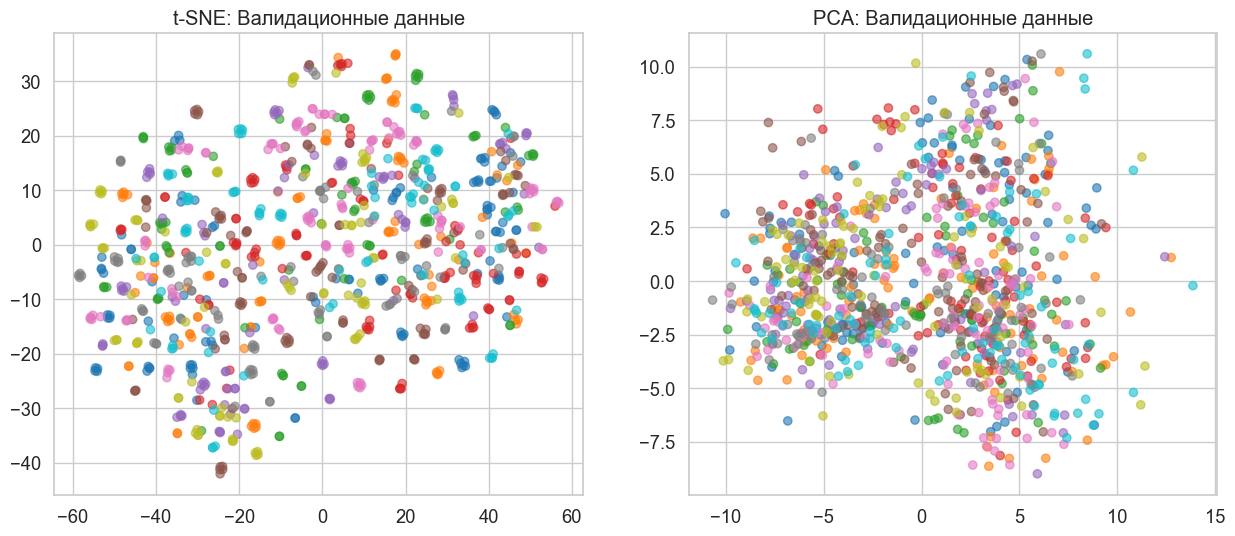

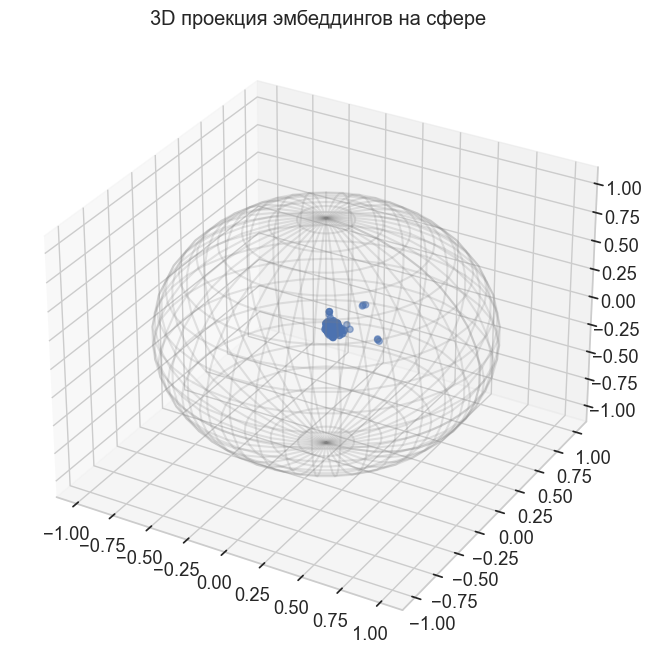

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def analyze_embeddings(model, dataloader, device, num_samples=1000):
    model.eval()
    embeddings = []
    labels = []
    
    # Собираем эмбеддинги
    with torch.no_grad():
        for images, targets in dataloader:
            emb = model(images.to(device))
            embeddings.append(emb.cpu())
            labels.append(targets)
            if len(embeddings)*dataloader.batch_size >= num_samples:
                break
    
    embeddings = torch.cat(embeddings)[:num_samples]
    labels = torch.cat(labels)[:num_samples]
    
    return embeddings.numpy(), labels.numpy()

def plot_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_tsne = tsne.fit_transform(embeddings)
    
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.title(f't-SNE: {title}')
    
    plt.subplot(122)
    plt.scatter(emb_pca[:, 0], emb_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.title(f'PCA: {title}')
    plt.show()


def plot_3d_sphere(embeddings):
    """3D визуализация эмбеддингов на сфере"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    norms = np.linalg.norm(embeddings, axis=1)
    normalized = embeddings / norms[:, np.newaxis]
    
    sample = np.random.choice(len(normalized), 500)
    ax.scatter(normalized[sample, 0], 
               normalized[sample, 1], 
               normalized[sample, 2], 
               alpha=0.5)
    
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="grey", alpha=0.2)
    
    ax.set_title('3D проекция эмбеддингов на сфере')
    plt.show()


embeddings, labels = analyze_embeddings(model, val_loader, device)

plot_embeddings(embeddings, labels, 'Валидационные данные')

plot_3d_sphere(embeddings)



#Визуализация латентного пространства показывает рассеянное распределение признаков, что затрудняет надежную кластеризацию.
#Распределение латентных векторов хаотично.

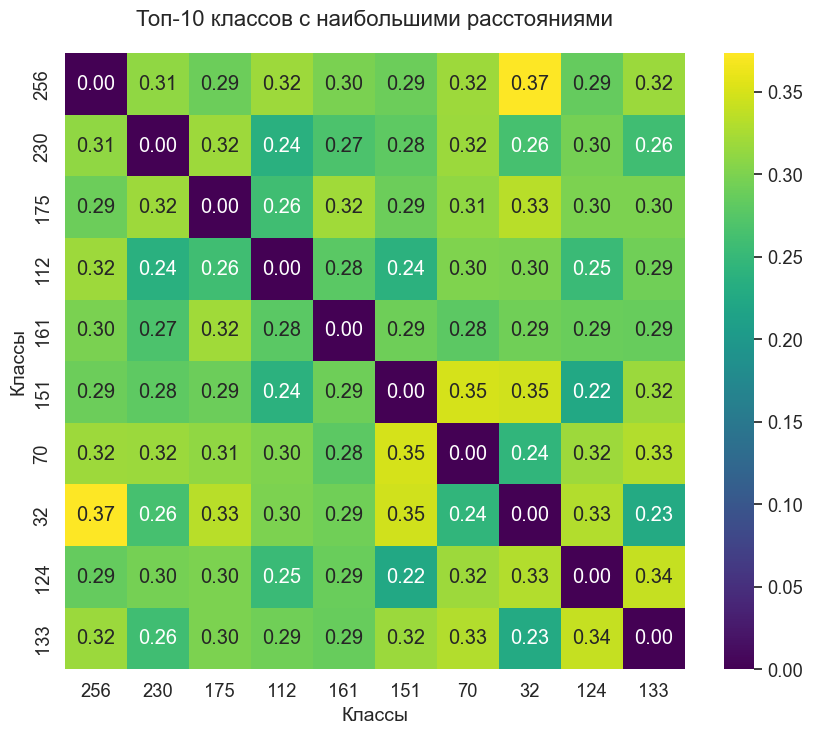

In [105]:
from sklearn.metrics import pairwise_distances
centroids = []
unique_labels = np.unique(labels)
for label in unique_labels:
    class_embeddings = embeddings[labels == label]
    centroid = np.mean(class_embeddings, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids) 

top_n = 10
mean_distances = np.mean(centroid_distances, axis=1) 
top_classes = np.argsort(mean_distances)[-top_n:]  

filtered_distances = centroid_distances[top_classes][:, top_classes]
filtered_labels = unique_labels[top_classes]

plt.figure(figsize=(10, 8))
sns.heatmap(
    filtered_distances,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    xticklabels=filtered_labels,
    yticklabels=filtered_labels
)
plt.title(f'Топ-{top_n} классов с наибольшими расстояниями', fontsize=16, pad=20)
plt.xlabel('Классы', fontsize=14)
plt.ylabel('Классы', fontsize=14)
plt.show()

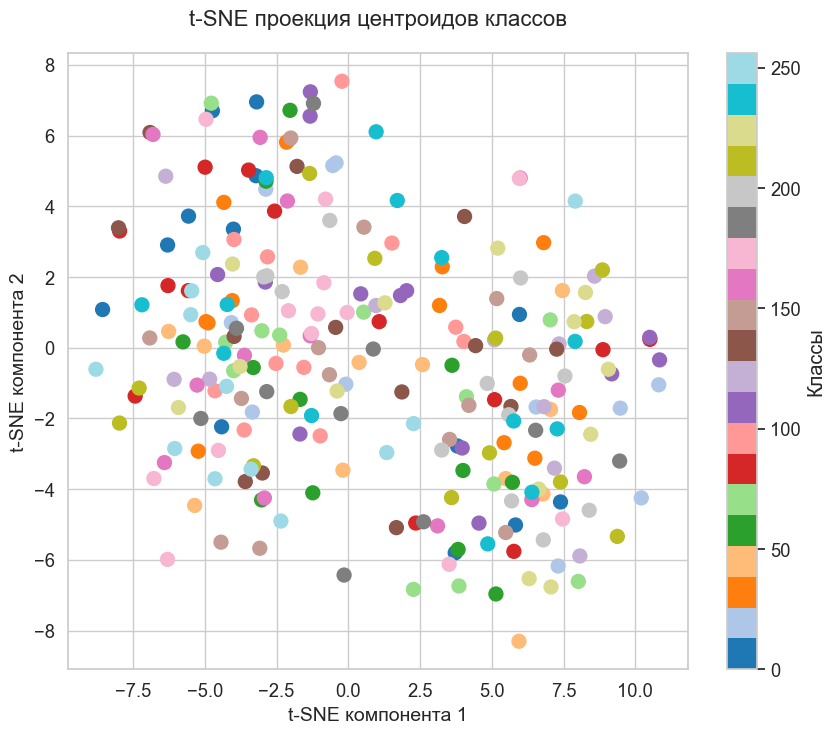

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



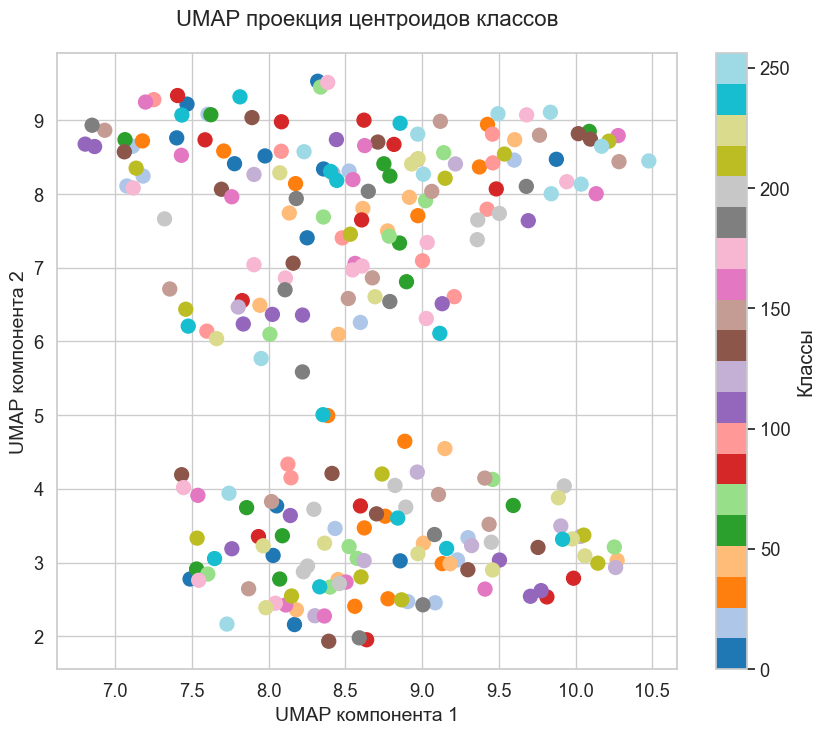

In [125]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
centroids_tsne = tsne.fit_transform(centroids)

plt.figure(figsize=(10, 8))
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], c=unique_labels, cmap='tab20', s=100)
plt.title('t-SNE проекция центроидов классов', fontsize=16, pad=20)
plt.xlabel('t-SNE компонента 1', fontsize=14)
plt.ylabel('t-SNE компонента 2', fontsize=14)
plt.colorbar(label='Классы')
plt.show()

reducer = umap.UMAP(random_state=42)
centroids_umap = reducer.fit_transform(centroids)

plt.figure(figsize=(10, 8))
plt.scatter(centroids_umap[:, 0], centroids_umap[:, 1], c=unique_labels, cmap='tab20', s=100)
plt.title('UMAP проекция центроидов классов', fontsize=16, pad=20)
plt.xlabel('UMAP компонента 1', fontsize=14)
plt.ylabel('UMAP компонента 2', fontsize=14)
plt.colorbar(label='Классы')
plt.show()

Всё, что можно сказать по визуализации простраства эмбеддингов - это то, что по графикам не видно какого либо распределения признаков, хоть и метрики показали неплохие результаты

Исследовать литературу, статьи по Face Recognition, написать literature review с обзором современных методов, улучшений сети и пайплайна.
==

Пайплайн распознавания лиц

Распознавание лиц — это технология, которая позволяет автоматически идентифицировать (распознать, кто на фото) или верифицировать (подтвердить, что на фото именно этот человек) человека на фото, видео или вживую. Для распознавания используют нейросети, которые умеют считывать и анализировать уникальные черты человеческого лица, а затем сверять их с базой.

**Detection**
Локализовать лица на изображении, даже в условиях засветки, поворотов или частичных окклюзий.
Методы:
 - Haar Cascades: Используют фильтры на основе интегральных изображений для поиска черт лица (глаза, нос, рот). Реализованы в OpenCV, но чувствительны к изменению освещения и ракурсов.

 - HOG + SVM: Гистограмма ориентированных градиентов (HOG) описывает текстуру лица, SVM классифицирует регионы. Метод быстрый, но уступает нейросетевым подходам.

Возможные модели для обучения
 - MTCNN (Multi-Task Cascaded CNN) обеспечивает точность 94% на наборе данных FDDB. Состоит из каскада трех сетей таких как, P-Net (быстро сканирует изображение для поиска регионов-кандидатов), R-Net (уточняет bounding boxes и отсеивает ложные срабатывания), O-Net (детектирует ключевые точки (5 точек: глаза, нос, углы рта))
 - RetinaFace: Добавляет к детекции предсказание 3D-меша лица и атрибутов (возраст, пол). Использует ResNet-50 и Feature Pyramid Network (FPN) для работы с масштабами.


**Alignment**
Нормализовать положение лица для уменьшения вариативности.
Landmarks. Стандартные модели предсказывают 68 точек (Dlib) или 106 точек (MobileNetV3). Координаты глаз и носа используются для аффинного преобразования, которое выравнивает лицо по шаблону.
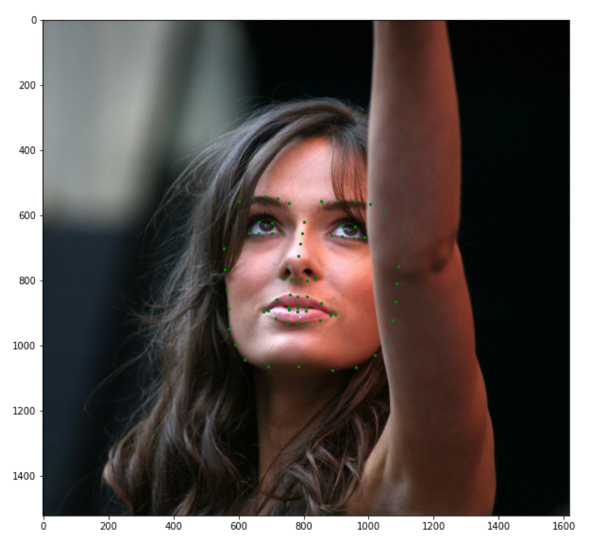
 
Библиотеки типа facenet-pytorch используют предобученные модели для обнаружения точек. Например, модель на основе ResNet-50 обучается с MSE-лоссом между предсказанными и истинными координатами.
 - 3D-выравнивание. Современные методы (3DDFA) восстанавливают 3D-позу лица, что улучшает точность при больших углах поворота.


**Feature Extraction**
Преобразовать нормализованное изображение в вектор (эмбеддинг), уникальный для каждого человека.

- FaceNet (Google)
Использует Triplet Loss:
Якорь (anchor), позитивный пример (positive), негативный пример (negative).
Лосс минимизирует расстояние между эмбеддингами якоря и позитива и максимизирует расстояние между якорем и негативом

 - ArcFace:
Модифицирует Softmax Loss, добавляя угловую маржу
ArcFace (ResNet-100) достигает 99.8% на LFW (Labeled Faces in the Wild).

- VGGFace: Серия моделей (VGGFace, VGGFace2) на базе ResNet-50/SENet, обученных на 3.3 млн изображений 9 тыс. человек.
Vision Transformers (ViT)
Разбивают изображение на патчи, обрабатываемые механизмами внимания.
ViT-Base достигает точности 98.7% на LFW, но требует больших вычислительных ресурсов.


Метрики расстояния, которые используются для того, чтобы определить принадлежат два изображения одному человеку: косинусное сходство, eвклидово расстояние.

Для ускорения поиска используются FAISS (Facebook) или Annoy, которые эффективно индексируют высокоразмерные данные (векторные базы данных).

**Современные улучшения**

 - MobileFaceNet: Сеть с 1 млн параметров, оптимизированная для мобильных устройств. Точность на LFW — 99.5%. Используется EfficientNet. Большие модели (например, ResNet-100) «учат» компактные сети (например, MobileNetV2), сохраняя 95% точности.

Контрастное обучение
 - SupCon Loss: Группирует эмбеддинги одного класса и разделяет разные классы.
 - ProxyNCA: Использует прокси-векторы классов для ускорения сходимости.
   
Лосс функции
 - AdaFace: Адаптирует маржу в зависимости от качества изображения (размытие).
 - CurricularFace: Планирует обучение, сначала фокусируясь на простых примерах, затем на сложных.
Обработка данных
Синтетические данные:
StyleGAN2: Генерирует фотореалистичные лица для дообучения моделей.
Домены: Добавление лиц в масках, в очках или с измененной прической.
Аугментации:
Рандомные патчи: Замена части изображения шумом для устойчивости к окклюзиям.
Mixup: Линейная комбинация двух изображений для увеличения датасета.
 
Метрики 

TAR@FAR
FAR (False Acceptance Rate): Доля ложных совпадений (например, 0.001 — 1 ошибка на 1000 попыток).
TAR (True Acceptance Rate): Доля верно распознанных лиц при заданном FAR.
Rank-n Accuracy
Rank-1: Точность, если первый результат в топе совпадает с истиной.
Rank-5: Хотя бы один из топ-5 результатов верен.
ROC-AUC
Площадь под ROC-кривой (True Positive Rate vs. False Positive Rate). Чем ближе к 1, тем лучше.

Этические вызовы и будущее

Bias
Датсеты типа CASIA-WebFace содержат дисбаланс по расе и полу. Например, ошибки распознавания для темнокожих (преступники) или женщин (в бикини) в 2-5 раз выше, чем для светлокожих мужчин.
Сбалансированные датасеты (BUPT-BalancedFace), перевзвешивание лосса для решения некорректного обучения

Приватность
- Дифференциальная приватность: Добавление шума к эмбеддингам.
- Федеративное обучение: Обучение моделей на децентрализованных данных (например, смартфонах)
  
Deepfakes:
Антиспуфинговые методы: Анализ моргания, текстуры кожи, артефактов GAN.
Мультимодальность:
Комбинация с голосом, походкой или тепловой картой лица.

Источники взяты из материалов к проекту:

Face recogtinion pipeline clearly explained (medium): https://medium.com/backprop-labs/face-recognition-pipeline-clearly-explained-f57fc0082750

Как работает распознавание лиц: https://trends.rbc.ru/trends/industry/6050ac809a794712e5ef39b7

Face landmark detection using PyTorch: https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

Face detection in Python: https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/

Пример метрики для подсчета качества систем распознавания лиц: http://www.eecs.qmul.ac.uk/~sgg/papers/ChengEtAl_PR2020.pdf (секция 3.2.3)


--- Также была попытка разбора Triplet Loss'a и в итоге не получилось добиться достаточной метрики

Во время реализации проекта больше всего времени было уделено изучению материала. Почему-то данная работа далась с трудом, так как модель на СЕ лоссе долго редактировалась для достижения нужной метрики. Но за счет этого было изучено много новых вариаций улучшения модели.
Реализация модели на arcface loss показала, насколько важно разбираться в вформулах и последовательности выполнения каждого пункта. 